In [2]:
import pandas as pn
reco_df = pn.read_csv("supervised_rmse_df.csv")
reco_df.head()

,Unnamed: 0,class,CIS,NIS,column,case
0,0,State-gov,1298,5223.0,workclass,1ftt
1,1,Without-pay,14,4132.0,workclass,1ftt
2,2,?,1836,5723.0,workclass,1ftt
3,3,Local-gov,2093,5855.0,workclass,1ftt
4,4,Self-emp-not-inc,2541,6191.0,workclass,1ftt


In [3]:
real_cis = reco_df[["class", "column","CIS"]]
real_cis.drop_duplicates(inplace=True)
real_cis.loc[:,"case"] = "real" 
real_cis = real_cis.rename(columns={"CIS":"count"})
real_cis.shape

reco_dff = reco_df[["class","column","case","NIS"]].rename(columns={"NIS":"count"})
print(reco_dff.shape)
print(reco_dff.shape[0] + real_cis.shape[0])

reco_dff.head()

reco_count = reco_dff.merge(real_cis, how="outer", on=["class","column","case","count"])
reco_count.shape

import re
def get_splitted_case(df):
    df["privacy"] = df["case"].map(lambda x: re.findall("\d+", x)[0] if x!="real" else x)
    df["real"] = df["case"].map(lambda x: re.findall("[^\d]",x)[0] if x!="real" else x)
    df["uniform"] = df["case"].map(lambda x: int(re.findall("[^\d]",x)[1] == "t") if x!="real" else x)
    df["uniform2"] = df["case"].map(lambda x: int(re.findall("[^\d]",x)[2] == "t") if x!="real" else x)
    return df

reco_df = get_splitted_case(reco_df)
reco_count = get_splitted_case(reco_count)

(5760, 4)
5856


/home/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/juanzinser/Workspace/Tesis/venv/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

\begin{tabular}{lrrr}
\toprule
{} &    0 &    1 &    2 \\
\midrule
0     &  1.0 &  0.0 &  0.0 \\
1     &  1.0 &  0.0 &  0.0 \\
2     &  1.0 &  0.0 &  0.0 \\
3     &  1.0 &  0.0 &  0.0 \\
4     &  1.0 &  0.0 &  0.0 \\
5     &  0.0 &  0.0 &  1.0 \\
6     &  1.0 &  0.0 &  0.0 \\
7     &  0.0 &  1.0 &  0.0 \\
8     &  1.0 &  0.0 &  0.0 \\
9     &  1.0 &  0.0 &  0.0 \\
total &  8.0 &  1.0 &  1.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &    0 &    1 &    2 \\
\midrule
0     &  0.0 &  0.5 &  0.5 \\
1     &  0.0 &  0.5 &  0.5 \\
2     &  0.0 &  0.5 &  0.5 \\
3     &  0.0 &  0.5 &  0.5 \\
4     &  0.0 &  0.5 &  0.5 \\
5     &  0.5 &  0.5 &  0.0 \\
6     &  0.0 &  0.5 &  0.5 \\
7     &  0.5 &  0.0 &  0.5 \\
8     &  0.0 &  0.5 &  0.5 \\
9     &  0.0 &  0.5 &  0.5 \\
total &  1.0 &  4.5 &  4.5 \\
\bottomrule
\end{tabular}



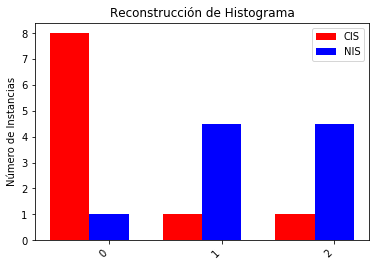

In [14]:
import multiprocessing
from sanitization_tools import *
import math
column_size=10

n=0
processed_cases = list()
reco_df = pn.DataFrame(columns=["case", "class", "CIS", "NIS"])
rmse_by_case = dict()

case = [6, 3, "exponential", False, True, True, None, False]
case_name = str(case[0])+("m" if case[7] else ("t" if case[3] else "f")) + ("t" if case[4] else "f") + \
            ("t" if case[5] else "f") #+ (str(case[6]) if (case[3] and not case[4]) else "")
case_name += '_' + str(case[1]) + '_' + str(case[2])
nclasses = case[1]
class_dist = case[2]
p = [1./nclasses]*nclasses if class_dist == 'uniform' else expo_weights(nclasses)
sim_data = np.random.choice(range(nclasses), column_size, p=p)
cis = pn.DataFrame.from_dict(Counter(sim_data), "index").reset_index()
cis.columns = ["class", "CIS"]
case2 = case
case2.pop(1)
case2.pop(1)
rel_privacy = math.ceil(float(case[0])/10*nclasses)
case2[0] = rel_privacy
field_dict = operator_model(sim_data, *case2)
nis = pn.DataFrame.from_dict(field_dict).sum(axis=0).reset_index()
nis.columns = ["class", "NIS"]
tmp_df = cis.merge(nis, how="left")
tmp_df['RMSE'] = (tmp_df['CIS'] - tmp_df['NIS']).map(lambda x: x*x)
tmp_df['CHI'] = (tmp_df['RMSE']/tmp_df['CIS'].map(lambda x: x if x>0.0 else np.nan))
rmse_one = math.sqrt(sum(tmp_df['RMSE'].values))
chi_one = np.nansum(tmp_df['CHI'].values)
# imprimir las tablas sumadas
#original
cis_df = pn.get_dummies(sim_data)
cis_df.loc["total"] = list(cis_df.sum(axis=0).values)
cis_df = cis_df.astype(float)
print(cis_df.to_latex())
# sanitizada
nis_df = pn.DataFrame.from_dict(field_dict)
nis_df.loc["total"] = list(nis_df.sum(axis=0).values)
nis_df
print(nis_df.to_latex())





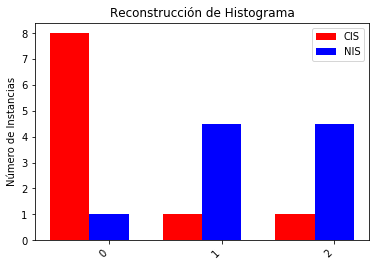

In [19]:
import numpy as np
from basic_units import cm, inch
import matplotlib.pyplot as plt

pr=3
N = len(tmp_df["class"].unique())
real_list = list()
real_order = list()
fig, ax = plt.subplots()
width_delta = 0.35         # the width of the bars
ind = np.arange(N)    # the x locations for the groups
real_colors = {"NIS":"b","CIS":"r","f":"g","m":"b"}
class_order = tmp_df.sort_values(by="class", ascending=True)["class"].values
width = 0 

cur_values = tmp_df.sort_values(by="class", ascending=True)["CIS"].values
cur_p = ax.bar(ind + width, cur_values, width_delta, color=real_colors["CIS"], bottom=0*cm)
real_list.append(cur_p)
real_order.append("CIS")
width += width_delta
cur_values = tmp_df.sort_values(by="class", ascending=True)["NIS"].values
cur_p = ax.bar(ind + width, cur_values, width_delta, color=real_colors["NIS"], bottom=0*cm)
real_list.append(cur_p)
real_order.append("NIS")
width += width_delta

ax.set_title('Reconstrucción de Histograma'.format(pr=pr))
ax.set_xticks(ind + width / 2)
ax.set_ylabel("Número de Instancias")
ax.set_xticklabels(class_order, rotation = 45, ha="right")
ax.legend([p[0] for p in real_list], tuple(real_order))
ax.yaxis.set_units(inch)
ax.autoscale_view()
plt.savefig("/home/juanzinser/Documents/plots/dataday/reconstruction_simulated_example".format(pr=pr))
plt.show()